In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

In [2]:
# Uncomment and run if you haven't previously installed these packages
# !pip install pillow tifffile natsort imagecodecs microfilm

In [3]:
from PIL import Image
import tifffile
from natsort import natsorted, ns
import imagecodecs
from microfilm import microplot
import skimage.io

# Set experiment-specific file locations

In [4]:
# Identify name and virtual machine location of meta data file
# Plate map should list the row and column in number format
# as well as any additional information - strain, media, treatment, etc - in columns
meta_data_name = '/home/stoops/Organoids/20210806_metadata.csv'

# Identify directory containing images
directory_name = '/data/Phenix-archive/Maga/210810-OrganoidTimelapse/organoids_calvin25_2021-08-06/Images/'

# Import Plate Map

In [5]:
# Import plate map from location on virtual machine
meta_data = pd.read_csv(meta_data_name)

# Check that metadata was imported and looks accurate
meta_data.head()

,row,col,drug,celltracker,replicate
0,4,4,untreated,1x,1
1,4,5,untreated,1x,2
2,4,6,untreated,1x,3
3,4,7,untreated,0.2x,1
4,4,8,untreated,0.2x,2


In [6]:
# Create list of columns
conditions = list(meta_data.columns)
if 'row' in conditions: conditions.remove('row')
if 'col' in conditions: conditions.remove('col')
conditions

['drug', 'celltracker', 'replicate']

In [7]:
# Create list of unique conditions
condition_lists = []

for cnd_type in conditions:
    uniques = np.sort(meta_data[cnd_type].unique())
    condition_lists.append(uniques)

condition_lists

[array(['tunicamycin', 'untreated'], dtype=object),
 array(['0.2x', '1x'], dtype=object),
 array([1, 2, 3])]

# Generate list of filenames matched with plate map

In [8]:
# Search experiment directory for tiff files and add to dataframe
all_paths_list = glob.glob(directory_name + '*.tiff')  
all_paths = pd.DataFrame(all_paths_list, columns = ['path'])

In [9]:
# Check that filenames are being added correctly
all_paths

,path
0,/data/Phenix-archive/Maga/210810-OrganoidTimel...
1,/data/Phenix-archive/Maga/210810-OrganoidTimel...
2,/data/Phenix-archive/Maga/210810-OrganoidTimel...
3,/data/Phenix-archive/Maga/210810-OrganoidTimel...
4,/data/Phenix-archive/Maga/210810-OrganoidTimel...
...,...
86395,/data/Phenix-archive/Maga/210810-OrganoidTimel...
86396,/data/Phenix-archive/Maga/210810-OrganoidTimel...
86397,/data/Phenix-archive/Maga/210810-OrganoidTimel...
86398,/data/Phenix-archive/Maga/210810-OrganoidTimel...


In [10]:
# Regular expression to extract image information from filename
match_str = r'r(?P<row>\d{2})c(?P<column>\d{2})f(?P<fov>\d{2})p(?P<z_position>\d{2})-ch(?P<channel>1|2)sk(?P<timepoint>\d{1,3})fk1fl1'
extracted = all_paths['path'].str.extract(match_str, expand=True)

# Concatenate extracted information to list of filenames
all_paths_ext = pd.concat([all_paths, extracted], axis=1)

# Convert data extracted from filename from string into integers
all_paths_ext['row'] = all_paths_ext['row'].astype(int)
all_paths_ext['column'] = all_paths_ext['column'].astype(int)
all_paths_ext['fov'] = all_paths_ext['fov'].astype(int)
all_paths_ext['z_position'] = all_paths_ext['z_position'].astype(int)
all_paths_ext['channel'] = all_paths_ext['channel'].astype(int)
all_paths_ext['timepoint'] = all_paths_ext['timepoint'].astype(int)

In [11]:
# Check that information was added to the dataframe
all_paths_ext.head()

,path,row,column,fov,z_position,channel,timepoint
0,/data/Phenix-archive/Maga/210810-OrganoidTimel...,4,4,7,3,1,98
1,/data/Phenix-archive/Maga/210810-OrganoidTimel...,5,7,9,3,1,46
2,/data/Phenix-archive/Maga/210810-OrganoidTimel...,4,9,8,3,1,71
3,/data/Phenix-archive/Maga/210810-OrganoidTimel...,4,6,9,3,1,71
4,/data/Phenix-archive/Maga/210810-OrganoidTimel...,5,8,8,3,1,46


In [12]:
# Check size of dataframe - should match number of images from experiment
all_paths_ext.shape

(86400, 7)

In [13]:
# Extract and store details about the experimental setup
nslices = all_paths_ext['z_position'].max()
print('Number of slices: ' + str(nslices))
# Choose a default slice number halfway through the stack
default_z = nslices/2

nchannels = all_paths_ext['channel'].max()
print('Number of channels: ' + str(nchannels))

ntimepoints = all_paths_ext['timepoint'].max()
print('Number of timepoints: ' + str(ntimepoints))

nfov = all_paths_ext['fov'].max()
print('Fields imaged per well: ' + str(nfov))

Number of slices: 4
Number of channels: 2
Number of timepoints: 100
Fields imaged per well: 9


In [14]:
# Matches information from the metadata to the information in the dataframe
all_files = pd.merge(all_paths_ext, meta_data, how='left', left_on=['row','column'], right_on=['row','col'])

# drops duplicate column info from the metadata
all_files = all_files.drop(['col'], axis=1)

In [15]:
# Create header rows to be able to use these for functions below
all_files.set_index(['drug','celltracker','fov','channel','timepoint','z_position','replicate'], inplace=True, drop=True)

In [16]:
all_files.head()

path  \
drug        celltracker fov channel timepoint z_position replicate                                                      
untreated   1x          7   1       98        3          1          /data/Phenix-archive/Maga/210810-OrganoidTimel...   
tunicamycin 0.2x        9   1       46        3          1          /data/Phenix-archive/Maga/210810-OrganoidTimel...   
untreated   0.2x        8   1       71        3          3          /data/Phenix-archive/Maga/210810-OrganoidTimel...   
            1x          9   1       71        3          3          /data/Phenix-archive/Maga/210810-OrganoidTimel...   
tunicamycin 0.2x        8   1       46        3          2          /data/Phenix-archive/Maga/210810-OrganoidTimel...   

                                                                    row  \
drug        celltracker fov channel timepoint z_position replicate        
untreated   1x          7   1       98        3          1            4   
tunicamycin 0.2x        9   1       46        3          1            5   
untreated   0.2x        8   1       71        3          3            4   
            1x          9   1       71        3          3            4   
tunicamycin 0.2x        8   1       46        3          2            5   

                                                                    column  
drug        celltracker fov channel timepoint z_position replicate          
untreated   1x          7   1       98        3          1               4  
tunicamycin 0.2x        9   1       46        3          1               7  
untreated   0.2x        8   1       71        3          3               9  
            1x          9   1       71        3          3               6  
tunicamycin 0.2x        8   1       46        3          2               8

In [17]:
all_files.sort_values(by=['drug','celltracker','fov','channel','timepoint','z_position','replicate'])

path  \
drug        celltracker fov channel timepoint z_position replicate                                                      
tunicamycin 0.2x        1   1       1         1          1          /data/Phenix-archive/Maga/210810-OrganoidTimel...   
                                                         2          /data/Phenix-archive/Maga/210810-OrganoidTimel...   
                                                         3          /data/Phenix-archive/Maga/210810-OrganoidTimel...   
                                              2          1          /data/Phenix-archive/Maga/210810-OrganoidTimel...   
                                                         2          /data/Phenix-archive/Maga/210810-OrganoidTimel...   
...                                                                                                               ...   
untreated   1x          9   2       100       3          2          /data/Phenix-archive/Maga/210810-OrganoidTimel...   
                                                         3          /data/Phenix-archive/Maga/210810-OrganoidTimel...   
                                              4          1          /data/Phenix-archive/Maga/210810-OrganoidTimel...   
                                                         2          /data/Phenix-archive/Maga/210810-OrganoidTimel...   
                                                         3          /data/Phenix-archive/Maga/210810-OrganoidTimel...   

                                                                    row  \
drug        celltracker fov channel timepoint z_position replicate        
tunicamycin 0.2x        1   1       1         1          1            5   
                                                         2            5   
                                                         3            5   
                                              2          1            5   
                                                         2            5   
...                                                                 ...   
untreated   1x          9   2       100       3          2            4   
                                                         3            4   
                                              4          1            4   
                                                         2            4   
                                                         3            4   

                                                                    column  
drug        celltracker fov channel timepoint z_position replicate          
tunicamycin 0.2x        1   1       1         1          1               7  
                                                         2               8  
                                                         3               9  
                                              2          1               7  
                                                         2               8  
...                                                                    ...  
untreated   1x          9   2       100       3          2               5  
                                                         3               6  
                                              4          1               4  
                                                         2               5  
                                                         3               6  

[86400 rows x 3 columns]

In [18]:
all_files.shape

(86400, 3)

# Plot preview images for strain and treatment of choice

In [19]:
all_files.xs('tunicamycin', axis=0)

path  \
celltracker fov channel timepoint z_position replicate                                                      
0.2x        9   1       46        3          1          /data/Phenix-archive/Maga/210810-OrganoidTimel...   
            8   1       46        3          2          /data/Phenix-archive/Maga/210810-OrganoidTimel...   
1x          8   1       21        3          3          /data/Phenix-archive/Maga/210810-OrganoidTimel...   
0.2x        9   1       21        3          3          /data/Phenix-archive/Maga/210810-OrganoidTimel...   
            5   1       61        3          1          /data/Phenix-archive/Maga/210810-OrganoidTimel...   
...                                                                                                   ...   
            3   2       90        2          2          /data/Phenix-archive/Maga/210810-OrganoidTimel...   
1x          2   1       42        4          1          /data/Phenix-archive/Maga/210810-OrganoidTimel...   
0.2x        8   1       6         1          3          /data/Phenix-archive/Maga/210810-OrganoidTimel...   
1x          1   2       25        3          3          /data/Phenix-archive/Maga/210810-OrganoidTimel...   
0.2x        2   2       90        2          1          /data/Phenix-archive/Maga/210810-OrganoidTimel...   

                                                        row  column  
celltracker fov channel timepoint z_position replicate               
0.2x        9   1       46        3          1            5       7  
            8   1       46        3          2            5       8  
1x          8   1       21        3          3            5       6  
0.2x        9   1       21        3          3            5       9  
            5   1       61        3          1            5       7  
...                                                     ...     ...  
            3   2       90        2          2            5       8  
1x          2   1       42        4          1            5       4  
0.2x        8   1       6         1          3            5       9  
1x          1   2       25        3          3            5       6  
0.2x        2   2       90        2          1            5       7  

[43200 rows x 3 columns]

In [20]:
def plot_specific_image(drg,CTr,rep,fov,ch,tp,zpos, **kwargs):
    
    # Generate the set of filenames where the conditions are equal to those set when calling the function
    image_path = all_files.xs((drg,CTr,rep,fov,ch,tp,zpos), level=['drug','celltracker','replicate','fov','channel','timepoint','z_position'])['path'].values[0]
    # print(image_path)

    # Load the images associated with the above filenames into numpy arrays
    img = plt.imread(image_path)
    img_min = np.percentile(img, 2)
    img_max = np.percentile(img, 99.8)
    # Display image with title and no axes
    plt.imshow(img, cmap='gray', vmin=img_min, vmax=img_max)
    plt.suptitle(drg + ' (' + CTr + ')')
    plt.xticks([])
    plt.yticks([])
    plt.show()


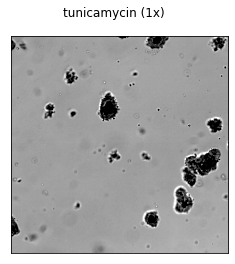

In [21]:
plot_specific_image(drg='tunicamycin',CTr='1x',rep=1,fov=2,ch=1,tp=1,zpos=4)

In [22]:
def plot_2channel_image(drg,CTr,rep=1,fov=5,tp=1,zpos=default_z, **kwargs):
    
    # Generate the set of filenames where the conditions are equal to those set when calling the function
    image_path = all_files.xs((drg,CTr,rep,fov,tp,zpos), level=['drug','celltracker','replicate','fov','timepoint','z_position'])['path'].values[:]
    paths_sorted = np.sort(image_path)
    
    # Create figure object
    fig, (ax1, ax2) = plt.subplots(1,2)
    
    # Read and plot the DIC image
    dic = plt.imread(paths_sorted[0])
    ax1.imshow(dic, cmap='gray')
    ax1.set_title('DIC')
    ax1.axis('off')
    
    # Read and plot the RFP image
    rfp = plt.imread(paths_sorted[1])
    rfp_min = np.percentile(rfp, 2)
    rfp_max = np.percentile(rfp, 99.8)
    ax2.imshow(rfp, cmap='gray', vmin=rfp_min, vmax=rfp_max)
    ax2.set_title('CellTracker')
    ax2.axis('off')
    
    plt.suptitle(drg + ' (' + CTr + ' CellTracker)', fontsize=20)
    plt.show()

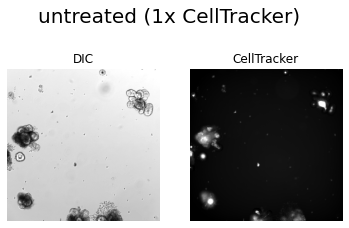

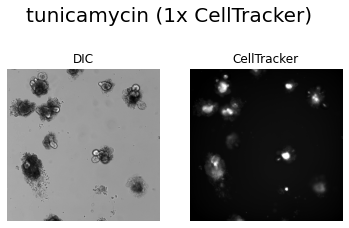

In [23]:
plot_2channel_image('untreated','1x',tp=100)
plot_2channel_image('tunicamycin','1x',tp=100)

In [26]:
# Define the step size for plotting the time series, i.e. every nth image
interval = int(ntimepoints/10)

def plot_timecourse_hrz(drg,CTr,rep=1,fov=5,ch=1,zpos=default_z, **kwargs):
    
    # Generate the set of filenames where the conditions are equal to those set when calling the function
    image_path = all_files.xs((drg,CTr,rep,fov,ch,zpos), level=['drug','celltracker','replicate','fov','channel','z_position'])['path'].values[:]
    paths_sorted = natsorted(image_path, key=lambda y: y.lower())
    
    # Create the figure object
    fig, ax = plt.subplots(1, 10, figsize=(30,4))
    
    # Loop through the list of filenames and plot every nth one based on the interval set above
    for i, col_num in enumerate(range(0,ntimepoints,interval)):
        a = ax[i]
        img = plt.imread(paths_sorted[col_num])
        a.imshow(img, cmap='gray')
        a.plot()
        a.title.set_text(str(col_num) + 'h')
        a.axis('off')
        
    plt.suptitle(str(drg) + ' replicate ' + str(rep), fontsize=20)
    plt.show()
    
    # Save timecourse file as an .svg file
    fig.savefig('timeseries/' + drg + '_' + CTr + '_r' + str(rep) + '_f' + str(fov) + '_z' + str(zpos) + '.svg', dpi=300)

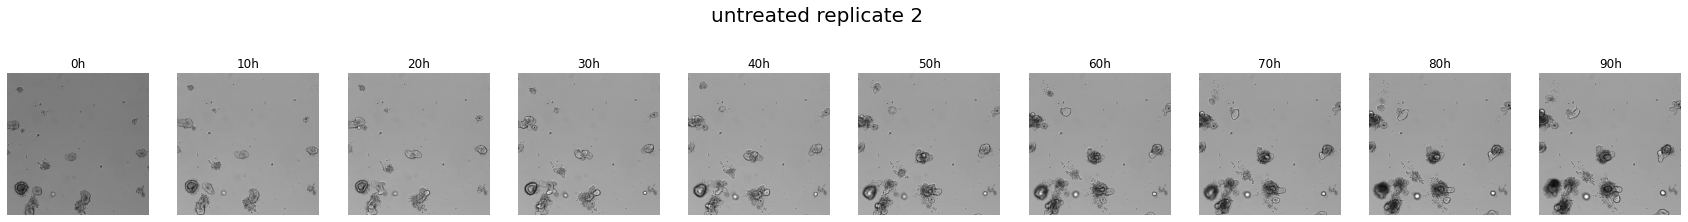

In [27]:
plot_timecourse_hrz('untreated','1x',rep=2, fov=3)

In [28]:
def create_z_stack(drg,CTr,rep=1,fov=5,ch=1,zpos=default_z, **kwargs):

    # Generate the set of filenames where the conditions are equal to those set when calling the function
    image_path = all_files.xs((drg,CTr,rep,fov,ch,zpos), level=['drug','celltracker', 'replicate','fov','channel','z_position'])['path'].values[:]
    # Sort the pathnames using a package that puts in natural order despite absence of leading zeroes
    paths_sorted = natsorted(image_path, key=lambda y: y.lower())
    
    # Create a stack and save as tiff to directory
    with tifffile.TiffWriter('zstacks/' + drg + '_' + CTr + '_r' + str(rep) + '_f' + str(fov) + '_c' + str(ch) + '_z' + str(zpos) + '.tif') as stack:
        for col_num in range(ntimepoints):
            stack.save(
                tifffile.imread(paths_sorted[col_num]),
                photometric='minisblack',
                contiguous=True
            )

In [29]:
# Create 2D time series z-stacks at the focal plane for both channels
create_z_stack('untreated','1x',rep=3,fov=1)
create_z_stack('untreated','1x',rep=3,fov=4)